In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt
import os
import math
import cv2
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()
train_images = train_images.reshape([60000,28,28,1])
test_images = test_images.reshape([10000,28,28, 1])

In [2]:
IMG_SIZE = 32

resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255)
])

train_images = np.array([resize_and_rescale(img) for img in train_images])
test_images = np.array([resize_and_rescale(img) for img in test_images])

In [3]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    
    n_kernel_lst = [64, 128, 256, 256, 512, 512, 512, 512]
    max_pool_layer_lst = [0, 1, 3, 5, 7]
    model = models.Sequential()

    for layer_idx, n_kernel in enumerate(n_kernel_lst):
        if layer_idx == 0:
            model.add(layers.Conv2D(filters=n_kernel, kernel_size=[3, 3], strides=(1, 1),\
                                    input_shape=(32, 32, 1), activation='relu', padding='same'))
            model.add(layers.BatchNormalization(axis=1, epsilon=1e-8, center=True))
        else:        
            model.add(layers.Conv2D(filters=n_kernel, kernel_size=[3, 3], strides=(1, 1),\
                                    activation='relu', padding='same'))
            model.add(layers.BatchNormalization(axis=1, epsilon=1e-8, center=True))
        if layer_idx in max_pool_layer_lst:
            model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
model.summary()    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [4]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
history = model.fit(train_images, train_labels, epochs=5, batch_size = 64,
                    validation_data=(test_images, test_labels))

Epoch 1/5
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
938/938 [==============================] - 69s 66ms/step - loss: 1.1187 - accuracy: 0.6637 - val_loss: 0.0536 - val_accuracy: 0.9865
Epoch 2/5
938/938 [==============================] - 60s 64ms/step - loss: 0.1003 - accuracy: 0.9765 - val_loss: 0.0820 - val_accuracy: 0.9831
Epoch 3/5
938/938 [==============================] - 60s 64ms/step - loss: 0.0702 - accuracy: 0.9844 - val_loss: 0.1423 - val_accuracy: 0.9790
Epoch 4/5
938/938 [==============================] - 60s 64ms/step - loss: 0.0556 - accuracy: 0.9879 - val_loss: 0.0547 - val_accuracy: 0.9910
Epoch 5/5
938/938 [==============================] - 60s 64ms/step - loss: 0.0501 - accuracy: 0.9892 - val_loss: 0.0677 - val_accuracy: 0.9853


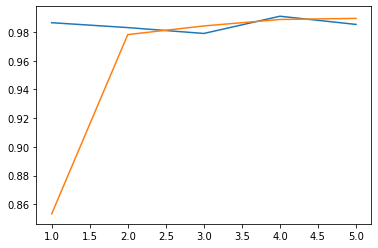

In [5]:
x_ax = [1,2,3,4,5]
plt.plot(x_ax, history.history['val_accuracy'])
plt.plot(x_ax, history.history['accuracy'])


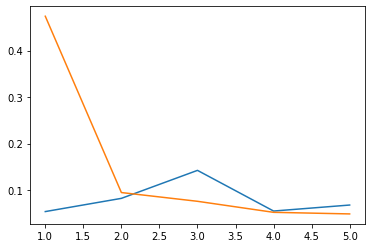

In [6]:
plt.plot(x_ax, history.history['val_loss'])
plt.plot(x_ax, history.history['loss'])

In [7]:
np.flip(train_images, 1).shape

(60000, 32, 32, 1)

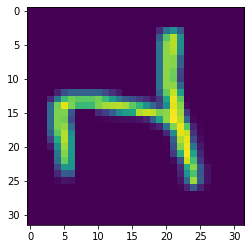

In [8]:
# flip from top to bottom
plt.imshow(tf.experimental.numpy.flip(train_images, 1)[2])

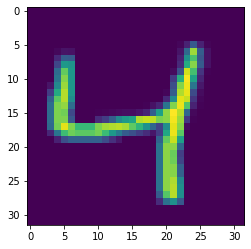

In [9]:
plt.imshow(train_images[2])

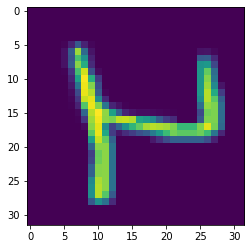

In [10]:
# flip from left to right
plt.imshow(tf.experimental.numpy.flip(train_images, 2)[2])

In [11]:
y_pred = model.predict(test_images)
scce = tf.keras.metrics.Accuracy()
scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy()

0.9853

In [12]:
# flip from left to right
ir_test_img = np.flip(test_images, 2)
y_pred = model.predict(ir_test_img)
scce = tf.keras.metrics.Accuracy()
scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy()

0.3675

In [13]:
# flip from top to bottom
ir_test_img = np.flip(test_images, 1)
y_pred = model.predict(ir_test_img)
scce = tf.keras.metrics.Accuracy()
scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy()

0.4042

In [14]:
lst_sigma = [0.01, 0.1, 1]
test_set_shape = test_images.shape
for sigma in lst_sigma:
    noise = tf.random.normal(shape=test_set_shape, stddev=sigma)
    y_pred = model.predict(test_images+0.1*noise)
    scce = tf.keras.metrics.Accuracy()
    print(scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy())

0.9853
0.9852
0.9797


In [15]:
train_images_aug = np.concatenate([train_images, np.flip(train_images, 1), np.flip(train_images, 2)])
train_labels_aug = np.concatenate([train_labels, train_labels, train_labels])

In [16]:
mirrored_strategy = tf.distribute.MirroredStrategy()
with mirrored_strategy.scope():
    n_kernel_lst = [64, 128, 256, 256, 512, 512, 512, 512]
    max_pool_layer_lst = [0, 1, 3, 5, 7]
    model = models.Sequential()

    for layer_idx, n_kernel in enumerate(n_kernel_lst):
        if layer_idx == 0:
            model.add(layers.Conv2D(filters=n_kernel, kernel_size=[3, 3], strides=(1, 1),\
                                    input_shape=(32, 32, 1), activation='relu', padding='same'))
            model.add(layers.BatchNormalization(axis=1, epsilon=1e-8, center=True))
        else:        
            model.add(layers.Conv2D(filters=n_kernel, kernel_size=[3, 3], strides=(1, 1),\
                                    activation='relu', padding='same'))
            model.add(layers.BatchNormalization(axis=1, epsilon=1e-8, center=True))
        if layer_idx in max_pool_layer_lst:
            model.add(layers.MaxPool2D(pool_size=(2, 2), strides=2, padding='valid'))
    model.add(layers.Flatten())
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(4096, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
model.summary()   

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 32, 32, 64)        640       
_________________________________________________________________
batch_normalization_8 (Batch (None, 32, 32, 64)        128       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
batch_normalization_9 (Batch (None, 16, 16, 128)       64        
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 8

In [17]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])
history = model.fit(train_images_aug, train_labels_aug, epochs=5, batch_size = 64,
                    validation_data=(test_images, test_labels))

Epoch 1/5
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 38 all-reduces with algorithm = nccl, num_packs = 1
2813/2813 [==============================] - 179s 62ms/step - loss: 0.8403 - accuracy: 0.7370 - val_loss: 0.0872 - val_accuracy: 0.9770
Epoch 2/5
2813/2813 [==============================] - 175s 62ms/step - loss: 0.1180 - accuracy: 0.9693 - val_loss: 0.0717 - val_accuracy: 0.9812
Epoch 3/5
2813/2813 [==============================] - 175s 62ms/step - loss: 0.0756 - accuracy: 0.9807 - val_loss: 0.0723 - val_accuracy: 0.9823
Epoch 4/5
2813/2813 [==============================] - 174s 62ms/step - loss: 0.0563 - accuracy: 0.9853 - val_loss: 0.0579 - val_accuracy: 0.9822
Epoch 5/5
2813/2813 [==============================] - 175s 62ms/step - loss: 0.0446 - accuracy: 0.9883 - val_loss: 0.0574 - val_accuracy: 0.9836


In [18]:
# flip from left to right
ir_test_img = np.flip(test_images, 2)
y_pred = model.predict(ir_test_img)
scce = tf.keras.metrics.Accuracy()
scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy()

0.9853

In [19]:
# flip from top to bottom
ir_test_img = np.flip(test_images, 1)
y_pred = model.predict(ir_test_img)
scce = tf.keras.metrics.Accuracy()
scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy()

0.985

In [ ]:
lst_sigma = [0.01, 0.1, 1]
test_set_shape = test_images.shape
for sigma in lst_sigma:
    noise = tf.random.normal(shape=test_set_shape, stddev=sigma)
    y_pred = model.predict(test_images+0.1*noise)
    scce = tf.keras.metrics.Accuracy()
    print(scce(test_labels, np.array([y_pred[i].argmax() for i in range(y_pred.shape[0])])).numpy())

0.9834
0.984
